<a href="https://colab.research.google.com/github/Dzy00/CHL5230-datathon4/blob/main/datathon4_Rose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns
import plotly.express as px
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

In [ ]:
# read the data
data = pd.read_csv('datathon4.csv')
data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [ ]:
print(data.shape)

(91713, 186)


In [ ]:
# Check how many patients there are
data['patient_id'].unique().shape

(91713,)

In [ ]:
# Check types of variables
data.dtypes

encounter_id                     int64
patient_id                       int64
hospital_id                      int64
hospital_death                   int64
age                            float64
                                ...   
leukemia                       float64
lymphoma                       float64
solid_tumor_with_metastasis    float64
apache_3j_bodysystem            object
apache_2_bodysystem             object
Length: 186, dtype: object

In [ ]:
# Count the number of missing values (NaN or None) in each column of the 'data' DataFrame
missing_value_counts = data.isnull().sum()
missing_value_counts

encounter_id                      0
patient_id                        0
hospital_id                       0
hospital_death                    0
age                            4228
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 186, dtype: int64

In [ ]:
# delete columns with missing values >50%
df = data.loc[:, data.isnull().mean() < .5]
df.isnull().sum().to_csv("missing count cleaned.csv")


In [316]:
# select certain variable (not all)


# Select variables based on redundancy/low variance/multicollinearity cutoff (>0.70)
data_selected = data[['hospital_death',
                # demographic
                # drop 'readmission_status' (no variance)
                'age','bmi','elective_surgery','ethnicity','gender','hospital_admit_source','icu_admit_source',
                'icu_stay_type','icu_type','pre_icu_los_days',
                # apache
                # drop 'bun_apache', 'creatinine_apache', 'glucose_apache', 'hematocrit_apache', 'sodium_apache', 'wbc_apache' (>0.70 collinearity w/ respective lab features)
                # drop 'heart_rate_apache', 'temp_apache' (>0.70 collinearity w/ respective vitals features)
                # drop 'apache_2_diagnosis' (redundant w/ 'apache_3j_diagnosis')
                'apache_3j_diagnosis','apache_post_operative','arf_apache',
                'gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache',
                'intubated_apache','map_apache','resprate_apache','ventilated_apache',
                # vitals
                # drop 'd1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min','d1_mbp_noninvasive_max','d1_mbp_noninvasive_min','h1_diasbp_noninvasive_max',
                # 'h1_diasbp_noninvasive_min','h1_mbp_noninvasive_max','h1_mbp_noninvasive_min','h1_sysbp_noninvasive_max','h1_sysbp_noninvasive_min',
                'd1_diasbp_max','d1_diasbp_min','d1_heartrate_max','d1_heartrate_min','d1_mbp_max','d1_mbp_min',
                'd1_resprate_max','d1_resprate_min','d1_spo2_max','d1_spo2_min','d1_sysbp_max','d1_sysbp_min',
                'd1_temp_max','d1_temp_min','h1_diasbp_max','h1_diasbp_min','h1_heartrate_max','h1_heartrate_min',
                'h1_mbp_max','h1_mbp_min','h1_resprate_max','h1_resprate_min','h1_spo2_max','h1_spo2_min',
                'h1_sysbp_max','h1_sysbp_min','h1_temp_max','h1_temp_min',
                # labs
                'd1_bun_max','d1_bun_min','d1_calcium_max','d1_calcium_min','d1_creatinine_max','d1_creatinine_min',
                'd1_glucose_max','d1_glucose_min','d1_hco3_max','d1_hco3_min','d1_hemaglobin_max','d1_hemaglobin_min',
                'd1_hematocrit_max','d1_hematocrit_min','d1_platelets_max','d1_platelets_min','d1_potassium_max','d1_potassium_min',
                'd1_sodium_max','d1_sodium_min','d1_wbc_max','d1_wbc_min',
                # apache comorbidity
                # drop 'apache_4a_hospital_death_prob','apache_4a_icu_death_prob'
                'aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis',
                # apache grouping
                # drop 'apache_2_bodysystem' (redundant w/ 'apache_3j_bodysystem')
                'apache_3j_bodysystem']]

print(data_selected.shape)
df = data_selected
print(df.shape) # 92 features left

(91713, 81)


In [206]:
data['hospital_death'].mean()

0.08630183289173836

In [177]:
# Define the column that will be used as the target for modeling or analysis
target_column = 'hospital_death'

# identify categorical variables
categorical_columns = ['ethnicity','hospital_admit_source','icu_admit_source',
                       'icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']

# numerical variables
numerical_columns = [c for c in data_selected.columns if c not in categorical_columns and c != target_column]


# Data Transformation

In [178]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, and accuracy
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc, acc

# Define a function to print the computed scores
def print_scores(conf_matrix, class_report, auc, acc):
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)


In [ ]:
!pip install category_encoders

In [ ]:
from sklearn.discriminant_analysis import StandardScaler
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from category_encoders import OneHotEncoder, TargetEncoder
warnings.filterwarnings('ignore')

In [ ]:
# # visualize categories under each categorical variable
# print(data['ethnicity'].unique())
# print(data['icu_admit_source'].unique())
# print(data['hospital_admit_source'].unique())
# print(data['icu_stay_type'].unique())
# print(data['apache_3j_bodysystem'].unique())
# print(data['icu_type'].unique())
# print(data['apache_2_bodysystem'].unique())


#data preparation + imputation

In [323]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
# Define the column that will be used as the target for modeling or analysis
target_column = 'hospital_death'

# identify categorical variables
categorical_columns = ['ethnicity', 'gender','hospital_admit_source','icu_admit_source',
                       'icu_stay_type','icu_type','apache_3j_bodysystem']

# numerical variables
numerical_columns = [c for c in df.columns if c not in categorical_columns and c != target_column]

# Encoding 'gender' column
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender']) # Male: 1, Female: 0


# Splitting the data into 70% training and 30% testing
train = df.sample(frac=0.7, random_state=11)
test = df.drop(train.index)

# features
X_train = train.drop('hospital_death', axis = 1)
# outcome
y_train = train['hospital_death']

# features
X_test = test.drop('hospital_death', axis = 1)
# outcome
y_test = test['hospital_death']

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# impute numerical columns with median
num_transformer = SimpleImputer(strategy = 'median')

# impute categorical columns with the most frequent value
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('one_hot_encoder', OneHotEncoder())
    ])

# initialize a column transformer that handels imputation and encoding
ct = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
        ],
    remainder='passthrough')


# Fit the ColumnTransformer to the data
ct.fit(X_train)
ct.fit(X_test)

X_1 = ct.fit(X_train)

# Here you can transform the data and convert to DataFrame with the new column names
X_resampled = pd.DataFrame(ct.transform(X_train), columns=ct.get_feature_names_out())
X_test = pd.DataFrame(ct.transform(X_test), columns=ct.get_feature_names_out())

# X_resampled.dtypes.to_csv("variables after one-hot encoding")


# Normalizing data
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.fit_transform(X_test)

# undersample
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_resampled, y_res = undersample.fit_resample(X_resampled, y_train)
upsample = SMOTE(sampling_strategy=1)
X_resampled, y_res = upsample.fit_resample(X_resampled, y_res)

# smt = SMOTE(sampling_strategy=1, random_state=42)
# X_resampled, y_res = smt.fit_resample(X_resampled, y_train)


In [324]:
print(X_resampled.shape)

(22248, 124)


In [325]:
print(y_res.shape)

(22248,)


In [326]:
# Logistic regression feature selection

# Initialize a Logistic Regression model
model = LogisticRegression()

# Define a StratifiedKFold cross-validation
cv = StratifiedKFold(3)

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='roc_auc',  # Specify the scoring metric (ROC AUC in this case)
    min_features_to_select=1,
)

rfecv.fit(X_resampled, y_res)
# Print the optimal number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 106


In [327]:
# which columns used and which wasn't
rfecv.support_
# features ranking low is better
rfecv.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1, 19,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 16,  1,  1,  1,  1,  3,  1,
        1,  1,  1, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 15, 17,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  7,  1,  1,  1,  5,  1,  1,
        1,  1,  1,  1,  1,  1, 12,  1, 14, 13, 11,  1,  1,  1,  8,  1,  1,
        1,  1,  1,  1,  1, 18,  1,  9,  1,  6,  1,  2,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1])

In [328]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X_1 = pd.DataFrame(ct.transform(X_train), columns=ct.get_feature_names_out())
print(X_1.columns[rfecv.support_])
X_1.columns[rfecv.support_].shape


Index(['num__age', 'num__bmi', 'num__elective_surgery',
       'num__pre_icu_los_days', 'num__apache_3j_diagnosis',
       'num__apache_post_operative', 'num__arf_apache', 'num__gcs_eyes_apache',
       'num__gcs_motor_apache', 'num__gcs_unable_apache',
       ...
       'cat__6_2', 'cat__6_3', 'cat__6_4', 'cat__6_5', 'cat__6_6', 'cat__6_7',
       'cat__6_8', 'cat__6_9', 'cat__6_10', 'cat__6_11'],
      dtype='object', length=106)


(106,)

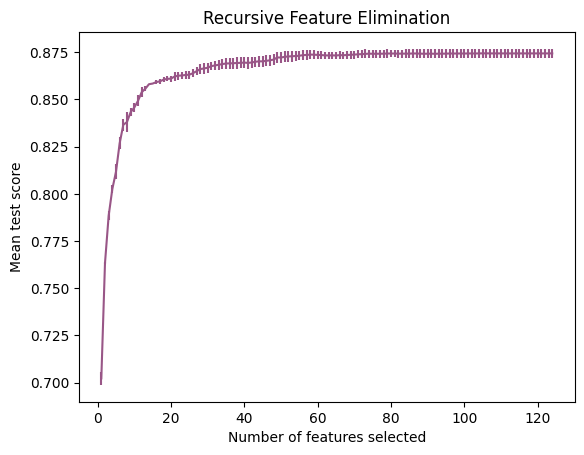

In [329]:
# Calculate the number of different feature selections tested
n_scores = len(rfecv.cv_results_["mean_test_score"])

# Create a new figure for plotting
plt.figure()

# Set labels for the x and y axes
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")

# Plot the mean test scores with error bars
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
    color='#995687'  # Change the color to green
)

# Set the title for the plot
plt.title("Recursive Feature Elimination")

# Show the plot
plt.show()


In [330]:


# Select only the features that were chosen by RFECV
X_train = X_resampled[:, rfecv.support_]
X_test = X_test[:, rfecv.support_]

# Initialize and train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_res)

# Make predictions on the test and training sets
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Calculate evaluation metrics and scores for the test and training sets
conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, y_test)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

======== Training Set ==========
AUC :  0.7926935263705643
Accuracy :  0.9237371298618359
Confusion Matrix:
[[57875  4134]
 [  762  1428]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     62009
           1       0.26      0.65      0.37      2190

    accuracy                           0.92     64199
   macro avg       0.62      0.79      0.66     64199
weighted avg       0.96      0.92      0.94     64199

======== Test Set ==========
AUC :  0.6197944277674535
Accuracy :  0.7935232972305009
Confusion Matrix:
[[19975   495]
 [ 5186  1858]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.98      0.88     20470
           1       0.79      0.26      0.40      7044

    accuracy                           0.79     27514
   macro avg       0.79      0.62      0.64     27514
weighted avg       0.79      0.79      0.75     27514



#Neural Networks

In [275]:
# importing PyTorch library as 't' for convenience
import torch as t

# importing other necessary libraries
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# importing PyTorch modules for building neural networks
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

In [276]:
# Defining the input to the neuron - a single example with 3 features
X = np.array([
    [0, 1, 2]
])

# Defining the expected output for the given input
Y = np.array([
    [1]
])

In [277]:
# Initializing the weights randomly for 3 inputs and 1 output
W = t.randn((3,1))
print(W)
print(W.dtype) # Checking the data type of the weights tensor
print(W.shape) # Checking the shape of the weights tensor
print('===========')

# Initializing the bias as a tensor with a single zero element
B = t.zeros((1,1))
print(B)
print(B.dtype) # Checking the data type of the bias tensor
print(B.shape) # Checking the shape of the bias tensor

tensor([[ 0.3383],
        [-1.1732],
        [-0.8590]])
torch.float32
torch.Size([3, 1])
tensor([[0.]])
torch.float32
torch.Size([1, 1])


In [278]:
# Converting the input array to a PyTorch Tensor and performing matrix multiplication with the weights
XW = t.Tensor(X) @ W
print(XW)

# Adding the bias to the result of the matrix multiplication
XW_B = XW + B
print(XW_B)

tensor([[-2.8912]])
tensor([[-2.8912]])


In [279]:
# Applying the hyperbolic tangent activation function element-wise to the result
output = tanh(XW_B)
print(output)

tensor([[-0.9939]])


In [331]:
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 5
hidden_units_layer_2 = 5

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((106, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)

# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)

# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

In [281]:
# Define the forward pass of the neural network
def forward(input):
    # First hidden layer with tanh activation
    out = tanh(input @ W1 + B1)

    # Second hidden layer with tanh activation
    out = tanh(out @ W2 + B2)

    # Output layer with sigmoid activation (since it's a binary classification problem)
    out = sigmoid(out @ W3 + B3)
    return out

In [282]:
# Convert the training data to PyTorch tensors
X = t.Tensor(X_train).type(t.float32)
Y = t.Tensor(y_res).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 2000
learning_rate = 0.01
batch_size = 32

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

In [283]:
train_loss_list = []

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X)

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

    # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

KeyboardInterrupt: ignored

Text(0, 0.5, 'loss')

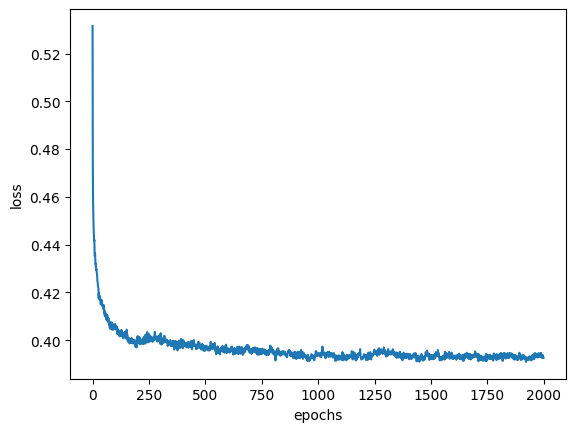

In [231]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

# Evaluating Model Performance on Validation Data

In [332]:
# X_train.shape
X_test.shape

(27514, 106)

In [335]:
number_of_input_features = 106  # Number of input features in the dataset

# Reduced number of hidden units to 5 and just using 1 hidden layer
number_of_hidden_units = 5# Number of hidden units in the neural network
epochs = 1000 # Number of training epochs
learning_rate = 0.001  # Learning rate for the optimizer
dropout_probablity = 0.6  # Probability of dropping out a neuron in dropout layer

# Convert training and testing data to PyTorch tensors
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(y_res).type(t.float32)
X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(y_test).type(t.float32)

# Create a training dataset and data loader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    Tanh(),  # Add Tanh activation function
    Dropout(dropout_probablity),  # Dropout layer to prevent overfitting
    Linear(number_of_hidden_units, 1),  # Another linear layer
    Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Binary Cross-Entropy Loss
loss_fn = t.nn.BCELoss()

train_accuracy_list = []  # List to store training accuracy
validation_accuracy_list = []  # List to store validation accuracy

# Training loop
for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []  # List to store losses for each epoch

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Calculate the loss
        loss = loss_fn(probs.view(-1), Y)
        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradients and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        print(f'epoch {epoch}/{epochs} ---> train_accuracy: {train_accuracy}, validation_accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

epoch 0/1000 ---> train_accuracy: 0.7932847738265991, validation_accuracy: 0.7620120644569397
epoch 1/1000 ---> train_accuracy: 0.8002067804336548, validation_accuracy: 0.779639482498169
epoch 2/1000 ---> train_accuracy: 0.8007910847663879, validation_accuracy: 0.7810205817222595
epoch 3/1000 ---> train_accuracy: 0.7994875907897949, validation_accuracy: 0.7809842228889465
epoch 4/1000 ---> train_accuracy: 0.7995774745941162, validation_accuracy: 0.7838918566703796
epoch 5/1000 ---> train_accuracy: 0.8007461428642273, validation_accuracy: 0.7874172925949097
epoch 6/1000 ---> train_accuracy: 0.8012855052947998, validation_accuracy: 0.7840008735656738
epoch 7/1000 ---> train_accuracy: 0.802813708782196, validation_accuracy: 0.7818201780319214
epoch 8/1000 ---> train_accuracy: 0.8010607957839966, validation_accuracy: 0.7820745706558228
epoch 9/1000 ---> train_accuracy: 0.8035328984260559, validation_accuracy: 0.7814203500747681
epoch 10/1000 ---> train_accuracy: 0.802813708782196, validati

(0.75, 0.85)

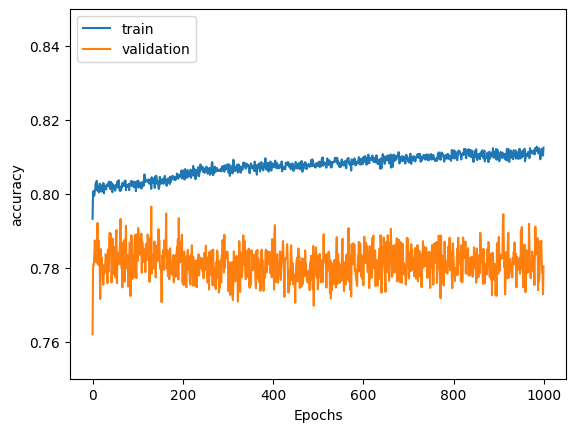

In [338]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.ylim(0.75,0.85)


In [302]:
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Regularization
# Deep neural networks are prone to overfitting if there is not much data available during training.

# Define hyperparameters
number_of_input_features = 93
number_of_hidden_units = 3
epochs = 100
learning_rate = 0.001
batch_size = 32
landa = 0.01  # Regularization term (lambda)

# Prepare the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(y_res).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    nn.Tanh(),  # Tanh activation function
    nn.Linear(number_of_hidden_units, 1),  # Another linear layer
    nn.Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Epoch 0/100 ---> Train Accuracy: 0.8021695017814636, Validation Accuracy: 0.8360471129417419
Epoch 1/100 ---> Train Accuracy: 0.8107994794845581, Validation Accuracy: 0.8586174249649048
Epoch 2/100 ---> Train Accuracy: 0.8099604249000549, Validation Accuracy: 0.8631242513656616
Epoch 3/100 ---> Train Accuracy: 0.8104998469352722, Validation Accuracy: 0.8683215975761414
Epoch 4/100 ---> Train Accuracy: 0.8099005222320557, Validation Accuracy: 0.8646507263183594
Epoch 5/100 ---> Train Accuracy: 0.8098405599594116, Validation Accuracy: 0.8589808940887451
Epoch 6/100 ---> Train Accuracy: 0.8109792470932007, Validation Accuracy: 0.8582176566123962


KeyboardInterrupt: ignored

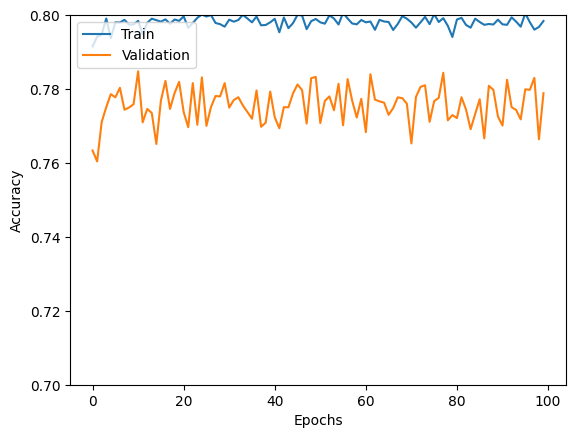

In [293]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.8)
plt.show()

Text(0, 0.5, 'loss')

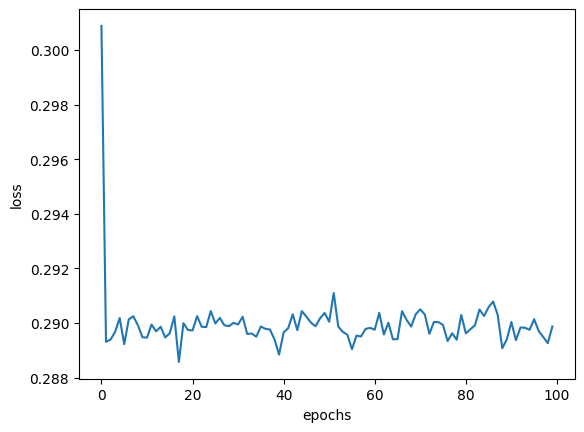

In [ ]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

In [240]:
# Evaluate Model Performance on Validation Data

# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X = t.Tensor(X_test).type(t.float32)  # Convert validation features to a PyTorch tensor
    Y = t.Tensor(y_test).type(t.float32)  # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X)  # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the validation loss
    print(loss.item())

    # Now, evaluate the model on the training data
    X = t.Tensor(X_train).type(t.float32)  # Convert training features to a PyTorch tensor
    Y = t.Tensor(y_res).type(t.float32)  # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs = forward(X)  # Pass training data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the training loss
    print(loss.item())

0.798692524433136
0.39142724871635437
